In [1]:
# AUTHOR: GAURAB POKHAREL 
# EMAIL: gpokhare@gmu.edu

import random 
import json 
import torch 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt 


from models.learning.lenet_5 import LeNet5
from models.unlearning.deep_obliviate import DeepObliviate 
from utils.general_utils import evaluate_accuracy_of_a_nn_model
from utils.data_loaders import load_mnist_data_deep_obliviate


# Supressing warnings about depricated features for now 
import warnings
warnings.filterwarnings(
    "ignore",
    message=r"You are using `torch.load` with `weights_only=False`.*",
    category=FutureWarning
)
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Setup models, load data 

In [2]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

train_X, train_y, test_X, test_y = load_mnist_data_deep_obliviate()


# Parameters
num_blocks = 500
epochs_per_block = 5
batch_size = 64
epsilon_values = [0.1]
num_points_to_unlearn_values = [10, 50]

# Define model and parameters
model = LeNet5()
params = {
    "num_blocks": num_blocks,
    "epochs_per_block": epochs_per_block,
    "batch_size": batch_size,
    "optimizer": optim.Adam(model.parameters(), lr=0.001),
    "criterion": nn.CrossEntropyLoss(),
    'dataset': 'MNIST'
}

# Instantiate DeepObliviate
deep_obliviate = DeepObliviate(model, params)

### Train a Base LeNet-5 model on MNIST

To make sure everything is working, and to establish a baseline accuracy

In [3]:
# Parameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

def train_lenet5(train_X, train_y, test_X, test_y):
    # DataLoader
    train_dataset = torch.utils.data.TensorDataset(train_X, train_y)
    test_dataset = torch.utils.data.TensorDataset(test_X, test_y)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    # Model, Loss, Optimizer
    device = torch.device('mps')
    model = LeNet5().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    baseline_accuracy = correct / total
    print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
    return baseline_accuracy 
base_acc = train_lenet5(train_X, train_y, test_X, test_y)

Epoch [1/10], Loss: 0.1442
Epoch [2/10], Loss: 0.0973
Epoch [3/10], Loss: 0.0406
Epoch [4/10], Loss: 0.1028
Epoch [5/10], Loss: 0.0885
Epoch [6/10], Loss: 0.0534
Epoch [7/10], Loss: 0.0426
Epoch [8/10], Loss: 0.0649
Epoch [9/10], Loss: 0.0715
Epoch [10/10], Loss: 0.0080
Baseline Accuracy: 0.9812


## Base Model Without Unlearning Anything 

BLOCK SIZES 101
Saving training results in folder: models/unlearning/checkpoints/LeNet5_dbcc137d81a9d523e500067b6e050574/original
No existing checkpoints found. Starting training from Block 1.
Training on Block 1/500
Block 1, Epoch 1/5, Loss: 2.3177
Block 1, Epoch 2/5, Loss: 2.2901
Block 1, Epoch 3/5, Loss: 2.2720
Block 1, Epoch 4/5, Loss: 2.2542
Block 1, Epoch 5/5, Loss: 2.2355
Saved model and optimizer state after Block 0.
Training on Block 2/500
Block 2, Epoch 1/5, Loss: 2.2246
Block 2, Epoch 2/5, Loss: 2.2050
Block 2, Epoch 3/5, Loss: 2.1830
Block 2, Epoch 4/5, Loss: 2.1587
Block 2, Epoch 5/5, Loss: 2.1319
Saved model and optimizer state after Block 1.
Training on Block 3/500
Block 3, Epoch 1/5, Loss: 2.1133
Block 3, Epoch 2/5, Loss: 2.0822
Block 3, Epoch 3/5, Loss: 2.0476
Block 3, Epoch 4/5, Loss: 2.0096
Block 3, Epoch 5/5, Loss: 1.9684
Saved model and optimizer state after Block 2.
Training on Block 4/500
Block 4, Epoch 1/5, Loss: 1.9451
Block 4, Epoch 2/5, Loss: 1.9039
Block 4, 

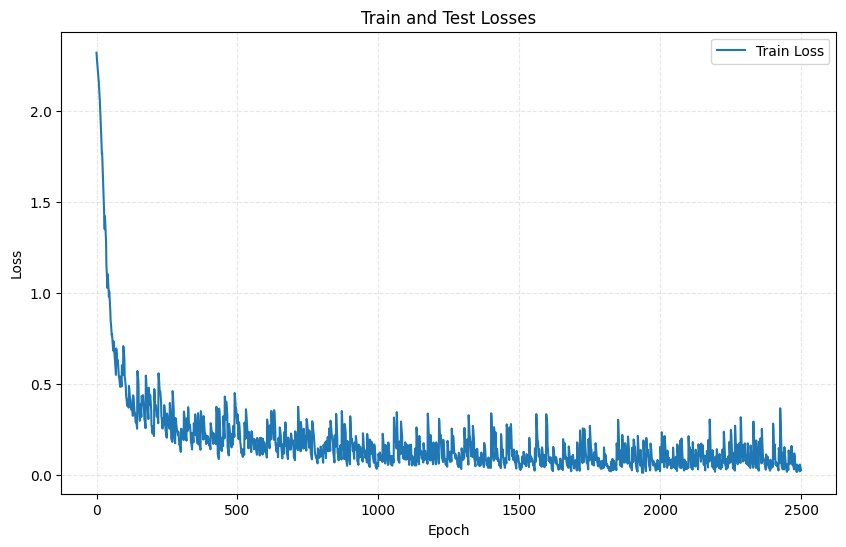

In [4]:
deep_obliviate.train(train_X, train_y)

## Perform Unlearning Task 

In [5]:
results = {}

for e in epsilon_values: 
    for num_points in num_points_to_unlearn_values: 
        all_indices = list(range(len(train_X)))
        removed_indices = random.sample(all_indices, num_points)
        
        d = deep_obliviate.unlearn(removed_indices, e)
        unlearn_acc = evaluate_accuracy_of_a_nn_model(deep_obliviate.model, test_X, test_y, device=device)
        key = f'{num_points}_{e}'
        results[key] = unlearn_acc
        print(f"[DeepObliviate] num_points={num_points}, eps={e}: accuracy={unlearn_acc:.4f}")

Data points to unlearn are in blocks: {352, 10, 148, 87, 348, 22, 409, 442, 188, 126}
Loaded optimizer state for Block 10.
Removed data points from Block 352.
Removed data points from Block 10.
Removed data points from Block 148.
Removed data points from Block 87.
Removed data points from Block 348.
Removed data points from Block 22.
Removed data points from Block 409.
Removed data points from Block 442.
Removed data points from Block 188.
Removed data points from Block 126.
Retrain Block 10, Epoch 1/5, Loss: 0.7930
Retrain Block 10, Epoch 2/5, Loss: 0.7664
Retrain Block 10, Epoch 3/5, Loss: 0.7337
Retrain Block 10, Epoch 4/5, Loss: 0.7008
Retrain Block 10, Epoch 5/5, Loss: 0.6706
Saved retrained model and optimizer state for Block 10.
Block 11: Residual Memory (Delta_k) = 46.662201
Retrain Block 11, Epoch 1/5, Loss: 0.7464
Retrain Block 11, Epoch 2/5, Loss: 0.7317
Retrain Block 11, Epoch 3/5, Loss: 0.7040
Retrain Block 11, Epoch 4/5, Loss: 0.6691
Retrain Block 11, Epoch 5/5, Loss: 0.6

#### Save results to json 

In [7]:
with open(f'experiment_results_{e}.json', 'w') as f:
    json.dump(results, f, indent=4)

## Make plot of results 

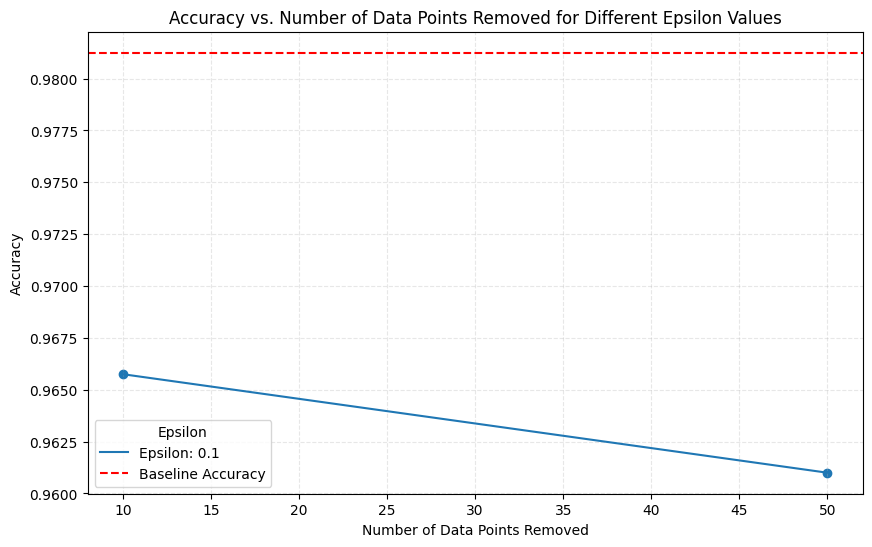

In [8]:
# Organizing data for plotting
epsilon_values = sorted(set(k[1] for k in results.keys()))
data_by_epsilon = {}

for key, accuracy in results.items():
    n, e = key.split('_')
    num_points = int(n) 
    epsilon = float(e)
    if epsilon in data_by_epsilon.keys(): 
        data_by_epsilon[epsilon].append((num_points, accuracy))
    else: 
        data_by_epsilon[epsilon] = [(num_points, accuracy)]

# Plotting
plt.figure(figsize=(10, 6))
baseline_accuracy = 0.9792  # Example baseline accuracy
for epsilon, data in data_by_epsilon.items():
    data = sorted(data, key=lambda x: x[0])  
    num_points = [x[0] for x in data]
    accuracies = [x[1] for x in data]
    plt.plot(num_points, accuracies, label=f"Epsilon: {epsilon}")
    plt.scatter(num_points, accuracies)  # Add dots


# Adding plot details
plt.axhline(y=base_acc, color='r', linestyle='--', label="Baseline Accuracy")
plt.xlabel("Number of Data Points Removed")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Data Points Removed for Different Epsilon Values")
plt.legend(title="Epsilon")
plt.grid(alpha=0.3, linestyle="--")
plt.show()